In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classified-netflix-movies-data/classified_data.csv


In [2]:
data = pd.read_csv('/kaggle/input/classified-netflix-movies-data/classified_data.csv')
data.head()

,Unnamed: 0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,cluster
0,0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,7
1,1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,11
2,2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",18
3,3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",14
4,4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,3


In [3]:
# X and Y for training
X = data.description.values
y = pd.get_dummies(data.cluster).values

print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (7787,)
y: (7787, 20)



# Text - Pre-processing and Model Building

In [54]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

from time import time
import keras.backend as K
from keras.layers import Dense, Input, LSTM, GRU, Dropout, SimpleRNN, Embedding
from keras.models import Model
from keras.optimizers import SGD, RMSprop, Adam
from keras import callbacks

In [5]:
# Text Pre-processing
token_data = data.description
maxlen = 1500 # Max number of frequently occuring words
training_samples = 800
validation_samples = 450
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(token_data)
seq = tokenizer.texts_to_sequences(token_data)
word_index = tokenizer.word_index
seq_data = pad_sequences(seq, maxlen=maxlen)

# Scaling of Data
scaler = MinMaxScaler()
seq_data = scaler.fit_transform(seq_data)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Splitting of Data
X_train, X_test, y_train, y_test = train_test_split(seq_data, y, test_size=0.2, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=56)

print("Training Set:- X_train: {} , y_train: {}".format(X_train.shape, y_train.shape))
print("Validation Set:- X_val: {} , y_val: {}".format(X_val.shape, y_val.shape))
print("Test Set:- X_test: {} , y_test: {}".format(X_test.shape, y_test.shape))

Training Set:- X_train: (6229, 1500) , y_train: (6229, 20)
Validation Set:- X_val: (779, 1500) , y_val: (779, 20)
Test Set:- X_test: (779, 1500) , y_test: (779, 20)


##  DNN Model

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model

In [9]:
# Baseline Model Hyper-parameters

BATCH_SIZE = 128
b_optimizer = 'rmsprop'
EPOCHS = 50
size = [X_train.shape[-1], 1000, 500, 20]

In [10]:
class DNNModel:
    """
    A deep neural network class class to create custom dnn architecture which could be trained and evaluated
    on any dataset.
    """
    
    def __init__(self, batch_size, epochs, size, optimizer, loss, activation_fn):
        
        """
        Parameters
        ----------
        
        batch_size: size of a batch for training data
        epochs:     number of epochs to train for
        size:       list of output dimesnions for each layer
        optimizer:  an optimizer algorithm could be optimizer object or string
        loss:       loss function to be used for optimization
        activation_fn: activation function for hidden layers
        """
        
        self.batch_size = batch_size
        self.epochs = epochs
        self.history = None
        self.loss = loss
        
        # Model Building
        n_layers = len(size) - 1

        # Input Layer
        input_data = Input(shape = (size[0], ), name='input')
        x = input_data

        # Hidden Layers
        for n in range(n_layers - 1):
            x = Dense(size[n+1], kernel_initializer = 'glorot_uniform', activation = activation_fn, name='dense_layer_{}'.format(n))(x)
            if n != n_layers - 2:
                x = Dropout(rate = 0.5, name='dropout_layer_{}'.format(n))(x)

        # Latent Layer
        out = Dense(size[-1], name='Output_layer', activation='softmax')(x)
        
        self.b_model = Model(inputs=input_data, outputs=out, name='basline_model')
        self.b_model.compile(optimizer=optimizer, loss=self.loss)
        
    def fit(self, training_data, validation_data, verbose):
        """
        This function fits the data to model.
        """
        
        self.history = self.b_model.fit(x=training_data[0], y=training_data[1],
                                  validation_data = validation_data, epochs = self.epochs, batch_size = self.batch_size,
                                  verbose = verbose)
        
    def plot_training(self):
        """
        Plots the progression of training and validation loss over the epochs
        """
        fig, ax = plt.subplots(1,1, dpi = 100)
        ax.plot(self.history.history['loss'], label='Training Loss')
        ax.plot(self.history.history['val_loss'], label='Validation Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(str(self.loss))
        plt.legend()
        plt.plot()
        
    def evaluation(self, test_data):
        """
        Evaluates the resulting model on test data and prints relevant information
        """
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        y_pred_prob = self.b_model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        eval_metric = self.b_model.evaluate(x=X_test, y=y_test)
        
        print(classification_report(np.argmax(y_test, axis=1), y_pred))
        
        return (y_pred_prob, y_pred, eval_metric)
    
    def plot_model(self):
        plot_model(self.b_model, to_file='baseline.png', show_shapes=True)
        
        
        

In [11]:
dnn_model = DNNModel(batch_size=BATCH_SIZE, epochs=EPOCHS, size=size, optimizer=b_optimizer, loss='categorical_crossentropy', activation_fn='relu')

In [12]:
dnn_model.plot_model()

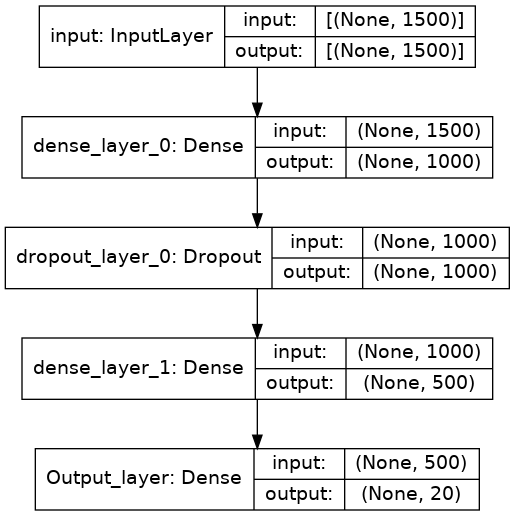

In [13]:
from IPython.display import Image
Image(filename='baseline.png')

In [14]:
dnn_model.fit(training_data=(X_train, y_train), validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
49/49 [==============================] - 2s 14ms/step - loss: 2.1539 - val_loss: 0.7414
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.6897 - val_loss: 0.4852
Epoch 3/50
49/49 [==============================] - 0s 5ms/step - loss: 0.4867 - val_loss: 0.3872
Epoch 4/50
49/49 [==============================] - 0s 6ms/step - loss: 0.3964 - val_loss: 0.3605
Epoch 5/50
49/49 [==============================] - 0s 5ms/step - loss: 0.3464 - val_loss: 0.3331
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.3442 - val_loss: 0.3435
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 0.3095 - val_loss: 0.2839
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2901 - val_loss: 0.2433
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2693 - val_loss: 0.2876
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2579 - val_loss: 0.3296
Epoch 11/50
49/49 

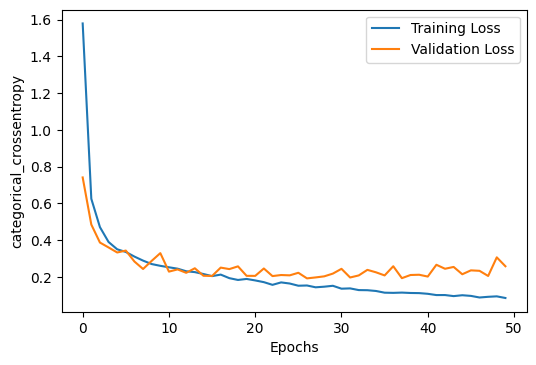

In [15]:
dnn_model.plot_training()

In [16]:
a, b, c = dnn_model.evaluation(test_data=(X_test, y_test))

25/25 [==============================] - 0s 2ms/step - loss: 0.2680
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        32
           1       0.97      0.80      0.88        41
           2       0.82      1.00      0.90        23
           3       0.96      0.92      0.94        50
           4       0.85      0.81      0.83        21
           5       0.96      0.82      0.89        33
           6       0.87      0.92      0.89        36
           7       0.94      0.93      0.94        72
           8       0.94      0.83      0.88        36
           9       0.88      0.95      0.91        22
          10       1.00      0.94      0.97        48
          11       0.90      1.00      0.95        37
          12       0.88      0.93      0.90        30
          13       0.93      1.00      0.96        37
          14       0.86      0.86      0.86        29
          15       0.86      0.98      0.92        50
          16 

## Sequential Model

In [95]:
class RecurrentNetwork:
     """
    A recurrent neural network class class to create custom RNN architecture which could be trained and evaluated
    on any dataset.
    """
    
    def __init__(self, layer, epoch, batch_size, optimizer, loss, input_param, name, size):
        
        """
        Parameters
        -----------
        
        layer: type of recurrent layer: SimpleRNN, LSTM, GRU
        batch_size: size of a batch for training data
        epochs:     number of epochs to train for
        size:       list of output dimesnions for each layer
        optimizer:  an optimizer algorithm could be optimizer object or string
        loss:       loss function to be used for optimization
        name:       name of the model
        input_param: array of [maclen, max_words]
        """
        
        self.BATCH_SIZE = batch_size
        self.EPOCH = epoch
        self.history = None
        self.loss = loss
        
        # Model Building
        inputs = Input(name='inputs',shape=[input_param[0]])
        emb = Embedding(input_param[1],500,input_length=input_param[0])(inputs)
        x = emb
        
        n_layers = len(size)
        
        for i in range(n_layers-1):
            x = layer(units = size[i], return_sequences = True, name='LSTM_layer_{}'.format(i+1))(x)
        
        x = layer(units = size[-1])(x)
        x = Dense(200, activation='relu')(x)
        out = Dense(20, activation='softmax')(x)
        
        self.model = Model(inputs = inputs, outputs = out, name = name)
        self.model.compile(optimizer=optimizer, loss=self.loss)
        
    
    def fit(self, training_data, validation_data, verbose, callbacks):
        """
        Fits the model on training_data along with specified callbacks
        """
        
        self.history = self.model.fit(x=training_data[0], y=training_data[1],
                                  validation_data = validation_data, epochs = self.EPOCH, batch_size = self.BATCH_SIZE,
                                  verbose = verbose, callbacks=callbacks)
        
    def plot_training(self):
        """
        Plots the progression of training and validation loss over the epochs
        """
        
        fig, ax = plt.subplots(1,1, dpi = 100)
        ax.plot(self.history.history['loss'], label='Training Loss')
        ax.plot(self.history.history['val_loss'], label='Validation Loss')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(str(self.loss))
        plt.legend()
        plt.plot()
        
    def evaluation(self, test_data):
        """
        Evaluates the resulting model on test data and prints relevant information
        """
        
        X_test = test_data[0]
        y_test = test_data[1]
        
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        eval_metric = self.model.evaluate(x=X_test, y=y_test)
        
        print(classification_report(np.argmax(y_test, axis=1), y_pred))
        
        return (y_pred_prob, y_pred, eval_metric)
    
    def plot_model(self):
        """
        Plots the model architecture
        """
        
        plot_model(self.model, to_file='recurrent.png', show_shapes=True)
         

In [96]:
input_param = [maxlen, max_words]

In [105]:
seq_checkpoint = callbacks.ModelCheckpoint(filepath = 'lstm.hdf5', save_weights_only= True,
                                                  save_best_only= True, monitor = 'val_loss', mode = 'min', verbose = 1)
seq_early_stopping = callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'min')
reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'min', factor = 0.1)
seq_callbacks = [seq_checkpoint, seq_early_stopping, reduce_lr]

In [107]:
# Deep LSTM Network
optimizer = SGD(lr=0.1, momentum=0.9)
lstm_rnn = RecurrentNetwork(layer = LSTM, epoch=100, batch_size=128, optimizer = optimizer, loss='categorical_crossentropy', 
                              input_param = input_param, name='LSTM_RNN', size = [1000, 500, 250])
lstm_rnn.plot_model()

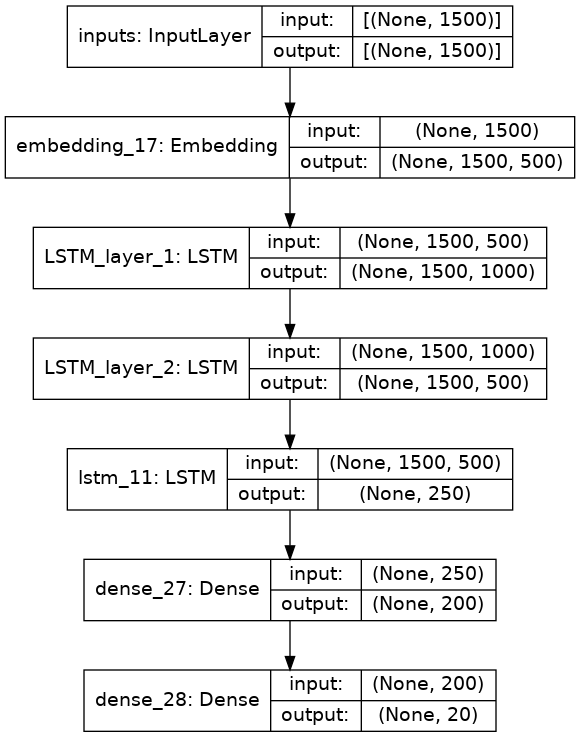

In [108]:
Image(filename='recurrent.png')

In [109]:
lstm_rnn.fit(training_data=(X_train, y_train), validation_data=(X_val, y_val), verbose=1, callbacks=seq_callbacks)

Epoch 1/100
49/49 [==============================] - 115s 2s/step - loss: 2.9533 - val_loss: 2.9072

Epoch 00001: val_loss improved from inf to 2.90723, saving model to lstm.hdf5
Epoch 2/100
49/49 [==============================] - 111s 2s/step - loss: 2.9235 - val_loss: 2.9038

Epoch 00002: val_loss improved from 2.90723 to 2.90375, saving model to lstm.hdf5
Epoch 3/100
49/49 [==============================] - 111s 2s/step - loss: 2.9218 - val_loss: 2.9072

Epoch 00003: val_loss did not improve from 2.90375
Epoch 4/100
49/49 [==============================] - 111s 2s/step - loss: 2.9244 - val_loss: 2.9028

Epoch 00004: val_loss improved from 2.90375 to 2.90284, saving model to lstm.hdf5
Epoch 5/100
49/49 [==============================] - 111s 2s/step - loss: 2.9228 - val_loss: 2.9030

Epoch 00005: val_loss did not improve from 2.90284
Epoch 6/100
49/49 [==============================] - 111s 2s/step - loss: 2.9136 - val_loss: 2.9027

Epoch 00006: val_loss improved from 2.90284 to 2.9

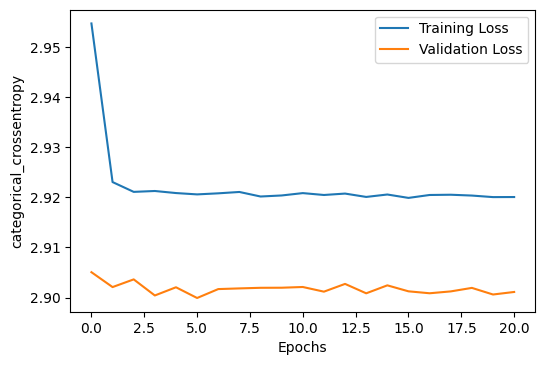

In [101]:
lstm_rnn.plot_training()

In [110]:
# Shallow LSTM network
seq_checkpoint = callbacks.ModelCheckpoint(filepath = 'shallow_lstm.hdf5', save_weights_only= True,
                                                  save_best_only= True, monitor = 'val_loss', mode = 'min', verbose = 1)
shallow_seq_callbacks = [seq_checkpoint, seq_early_stopping, lr_scheduler]

shallow_lstm = RecurrentNetwork(layer = LSTM, epoch=100, batch_size=128, optimizer = optimizer, loss='categorical_crossentropy', 
                              input_param = input_param, name='LSTM_RNN', size = [1000])

shallow_lstm.fit(training_data=(X_train, y_train), validation_data=(X_val, y_val), verbose=1, callbacks=shallow_seq_callbacks)

Epoch 1/100
49/49 [==============================] - 71s 1s/step - loss: 2.9980 - val_loss: 2.9975

Epoch 00001: val_loss improved from inf to 2.99753, saving model to shallow_lstm.hdf5
Epoch 2/100
49/49 [==============================] - 69s 1s/step - loss: 2.9977 - val_loss: 2.9975

Epoch 00002: val_loss improved from 2.99753 to 2.99753, saving model to shallow_lstm.hdf5
Epoch 3/100
49/49 [==============================] - 69s 1s/step - loss: 2.9978 - val_loss: 2.9975

Epoch 00003: val_loss did not improve from 2.99753
Epoch 4/100
49/49 [==============================] - 69s 1s/step - loss: 2.9977 - val_loss: 2.9975

Epoch 00004: val_loss improved from 2.99753 to 2.99753, saving model to shallow_lstm.hdf5
Epoch 5/100
49/49 [==============================] - 69s 1s/step - loss: 2.9977 - val_loss: 2.9975

Epoch 00005: val_loss improved from 2.99753 to 2.99753, saving model to shallow_lstm.hdf5
Epoch 6/100
49/49 [==============================] - 69s 1s/step - loss: 2.9977 - val_loss: 2

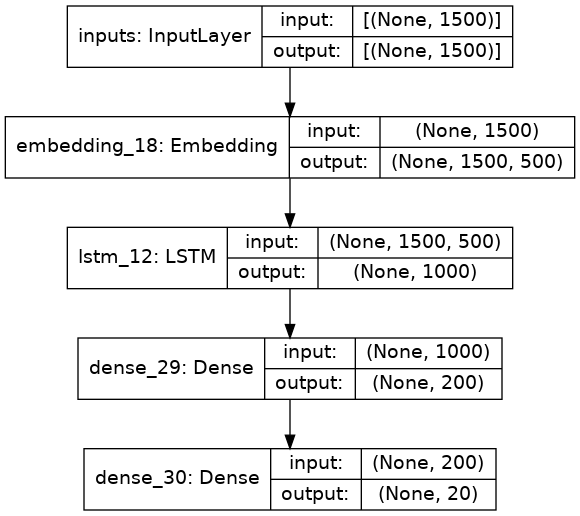

In [113]:
shallow_lstm.plot_model()
Image(filename='recurrent.png')


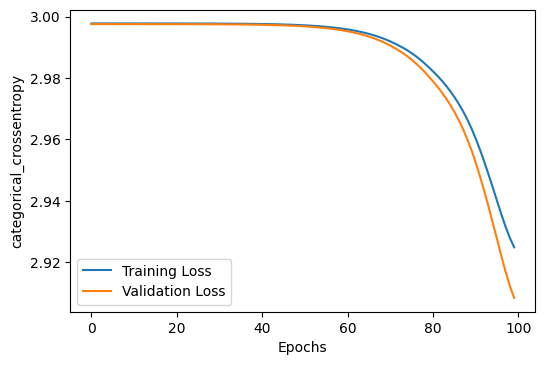

In [111]:
shallow_lstm.plot_training()

In [114]:
# Training it for another 100 iterations
shallow_lstm.fit(training_data=(X_train, y_train), validation_data=(X_val, y_val), verbose=1, callbacks=shallow_seq_callbacks)

Epoch 1/100
49/49 [==============================] - 69s 1s/step - loss: 2.9231 - val_loss: 2.9078

Epoch 00001: val_loss improved from 2.90842 to 2.90777, saving model to shallow_lstm.hdf5
Epoch 2/100
49/49 [==============================] - 69s 1s/step - loss: 2.9230 - val_loss: 2.9078

Epoch 00002: val_loss improved from 2.90777 to 2.90777, saving model to shallow_lstm.hdf5
Epoch 3/100
49/49 [==============================] - 69s 1s/step - loss: 2.9230 - val_loss: 2.9078

Epoch 00003: val_loss did not improve from 2.90777
Epoch 4/100
49/49 [==============================] - 69s 1s/step - loss: 2.9230 - val_loss: 2.9078

Epoch 00004: val_loss did not improve from 2.90777
Epoch 5/100
49/49 [==============================] - 69s 1s/step - loss: 2.9230 - val_loss: 2.9078

Epoch 00005: val_loss did not improve from 2.90777
Epoch 6/100
49/49 [==============================] - 69s 1s/step - loss: 2.9230 - val_loss: 2.9078

Epoch 00006: val_loss did not improve from 2.90777
Epoch 7/100
49/4